In [ ]:
import pandas as pd

df= pd.read_csv('/content/ERA5_wind_3_to_7_E_69.75_to_72_S_Nov2022_to_Feb_2023.csv')
print(df.head())
print(df.shape)
print(df.columns)

                  time          u         v
0           2022-11-01 -12.508618  0.059110
1  2022-11-01 01:00:00 -12.244280 -0.071583
2  2022-11-01 02:00:00 -11.925873 -0.098119
3  2022-11-01 03:00:00 -11.632283  0.082089
4  2022-11-01 04:00:00 -11.376995  0.237020
(2880, 3)
Index(['time', 'u', 'v'], dtype='object')


In [ ]:
Correlation_coefficient= df['u'].corr(df['v'])
print(Correlation_coefficient)

0.3598708128673104


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr


pearson_corr, pearson_p_value = pearsonr(df['u'], df['v'])
spearman_corr, spearman_p_value = spearmanr(df['u'], df['v'])


correlation_results = {
    'Pearson Correlation': pearson_corr,
    'Pearson p-value': pearson_p_value,
    'Spearman Correlation': spearman_corr,
    'Spearman p-value': spearman_p_value}

correlation_df = pd.DataFrame([correlation_results])
print(correlation_df)


   Pearson Correlation  Pearson p-value  Spearman Correlation  \
0             0.359871     8.658518e-89              0.358239   

   Spearman p-value  
0      6.028762e-88  


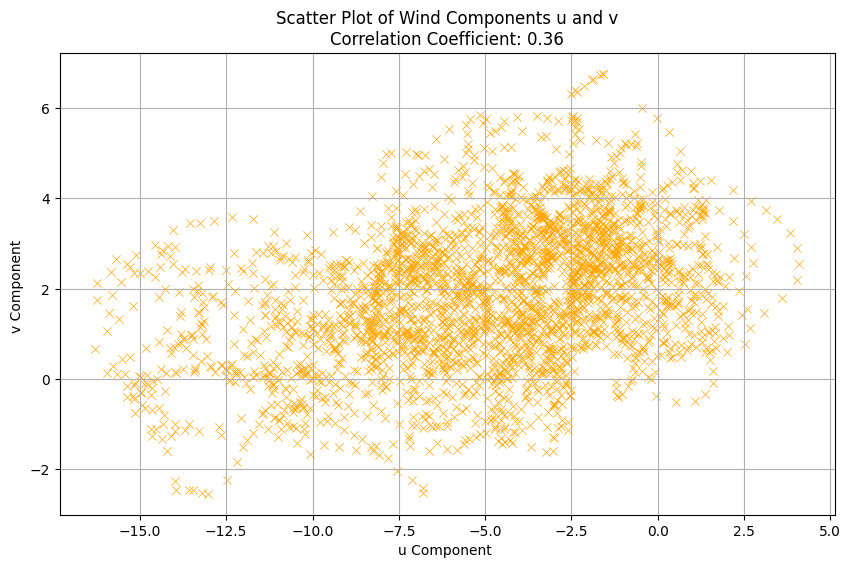

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='u', y='v', data=df,c='orange',marker='x')
plt.title(f'Scatter Plot of Wind Components u and v\nCorrelation Coefficient: {Correlation_coefficient:.2f}')
plt.xlabel('u Component ')
plt.ylabel('v Component ')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import re

# Load the data files
era5_file_path = '/content/ERA5_wind_3_to_7_E_69.75_to_72_S_Nov2022_to_Feb_2023.csv'
final_output_file_path = '/content/Final-Output.csv'

era5_df = pd.read_csv(era5_file_path)
final_output_df = pd.read_csv(final_output_file_path)


def correct_time_format(date_time_str):
    if re.match(r'^\d{4}-\d{2}-\d{2}$', date_time_str.strip()):
        return date_time_str.strip() + ' 00:00:00'
    return date_time_str.strip()
era5_df['time'] = era5_df['time'].map(correct_time_format)

def separate_date_time(date_time_str):
    match = re.match(r'(\d{4}-\d{2}-\d{2})(?:\s(\d{2}):(\d{2}):(\d{2}))?', date_time_str)
    if match:
        date_part = match.group(1)
        hour_part = match.group(2) if match.group(2) else '00'
        return date_part, hour_part
    return date_time_str, '00'

era5_df['Date'], era5_df['Hour'] = zip(*era5_df['time'].map(separate_date_time))
era5_df['Date'] = pd.to_datetime(era5_df['Date']).dt.date
era5_df['Hour'] = era5_df['Hour'].astype(int)
final_output_df['Date'] = pd.to_datetime(final_output_df['Dates']).dt.date
final_output_df['Hour'] = pd.to_datetime(final_output_df['Times']).dt.hour
merged_df = pd.merge(final_output_df, era5_df, left_on=['Date', 'Hour'], right_on=['Date', 'Hour'], how='left')
merged_df.to_csv('merged_output.csv', index=False)
print(merged_df)


<ipython-input-6-2b37be940486>:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  final_output_df['Hour'] = pd.to_datetime(final_output_df['Times']).dt.hour


         Image_Name Camera_Numbers  Temp(F)  Temp(C)       Dates     Times  \
0      11230006.JPG          Cam01     21.0     -6.1  11/23/2022   9:46:27   
1      11230015.JPG          Cam01     27.0     -2.8  11/23/2022  15:05:02   
2      11230018.JPG          Cam01     26.0     -3.3  11/23/2022  15:10:02   
3      11230021.JPG          Cam01     23.0     -5.0  11/23/2022  15:15:02   
4      11230026.JPG          Cam01     21.0     -6.1  11/23/2022  15:25:01   
...             ...            ...      ...      ...         ...       ...   
10310  01170171.JPG          Cam11     17.0     -8.3   1/17/2023  19:29:32   
10311  01170174.JPG          Cam11     17.0     -8.3   1/17/2023  19:34:32   
10312  01170177.JPG          Cam11     17.0     -8.3   1/17/2023  19:39:32   
10313  01170180.JPG          Cam11     17.0     -8.3   1/17/2023  19:44:32   
10314  01170186.JPG          Cam11     16.0     -8.9   1/17/2023  19:54:03   

       Bird_Number        Date  Hour                 time      

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


file_path = '/content/merged_output.csv'
data = pd.read_csv(file_path)


X = data[['u', 'v']].values
y = data['Bird_Number'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sgd = make_pipeline(StandardScaler(), SGDRegressor())
sgd.fit(X_train, y_train)
linear_feature = sgd.predict(X_train).reshape(-1, 1)
X_train = np.hstack((X_train, linear_feature))
linear_feature_test = sgd.predict(X_test).reshape(-1, 1)
X_test = np.hstack((X_test, linear_feature_test))
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))

print(f'Best RMSE: {best_rmse}')
print(f'Best Parameters: {best_params}')

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(best_rf_model, X, y, cv=kf, scoring='neg_mean_squared_error')
cross_val_rmse = np.sqrt(-cross_val_scores)
print(f'Cross-validated RMSE: {cross_val_rmse.mean()}')


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best RMSE: 0.3713834442321192
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Cross-validated RMSE: 0.3881196076388884


In [ ]:
feature_importances = best_rf_model.feature_importances_
for i, feature in enumerate(['u', 'v']):
    print(f'{feature} importance: {feature_importances[i]:.4f}')


u importance: 0.3051
v importance: 0.3055


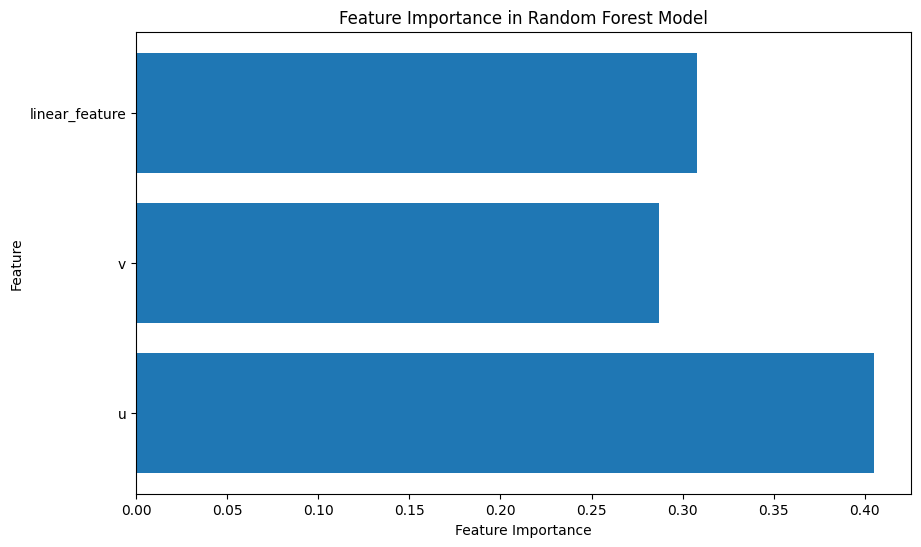

In [ ]:
import matplotlib.pyplot as plt
feature_importances = best_rf_model.feature_importances_
features = ['u', 'v', 'linear_feature']  # Include the engineered feature

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.show()

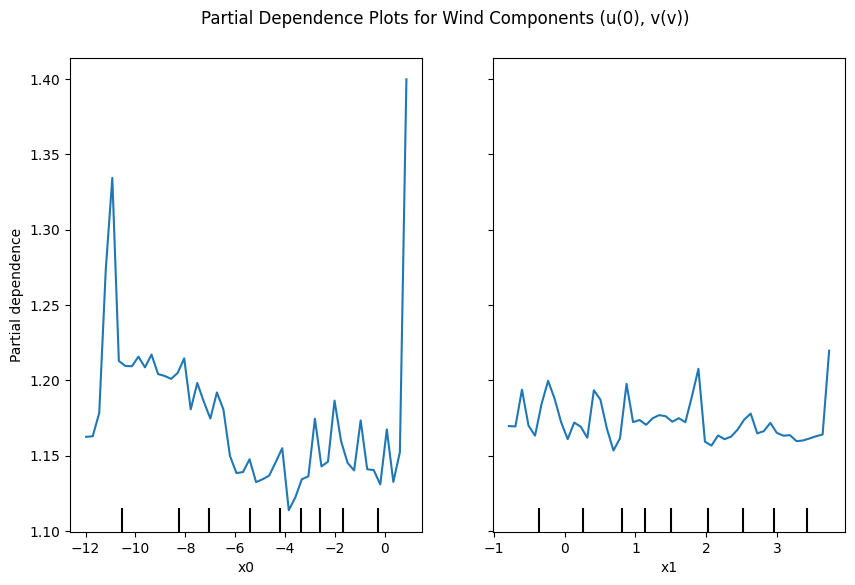

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

features = [0, 1]  # 0 for 'u', 1 for 'v'
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    best_rf_model, X_train, features, grid_resolution=50, ax=ax
)
plt.suptitle('Partial Dependence Plots for Wind Components (u(0), v(v))')
plt.subplots_adjust(top=0.9)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error


file_path = '/content/merged_output.csv'
data = pd.read_csv(file_path)
X = data[['u', 'v']].values
y = data['Bird_Number'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
gbm = GradientBoostingRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]}

grid_search = GridSearchCV(
    estimator=gbm,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2)

grid_search.fit(X_train, y_train)
best_gbm_model = grid_search.best_estimator_
best_params = grid_search.best_params_
y_pred_best_gbm = best_gbm_model.predict(X_test)
best_rmse_gbm = np.sqrt(mean_squared_error(y_test, y_pred_best_gbm))

print(f'Best GBM RMSE: {best_rmse_gbm}')
print(f'Best GBM Parameters: {best_params}')
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(best_gbm_model, X, y, cv=kf, scoring='neg_mean_squared_error')
cross_val_rmse = np.sqrt(-cross_val_scores)

print(f'Cross-validated RMSE: {cross_val_rmse.mean()}')
feature_importances = best_gbm_model.feature_importances_
for i, feature in enumerate(['u', 'v']):
    print(f'{feature} importance: {feature_importances[i]:.4f}')


Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
Best GBM RMSE: 0.37317386789280244
Best GBM Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
Cross-validated RMSE: 0.3879425738077157
u importance: 0.5081
v importance: 0.4919


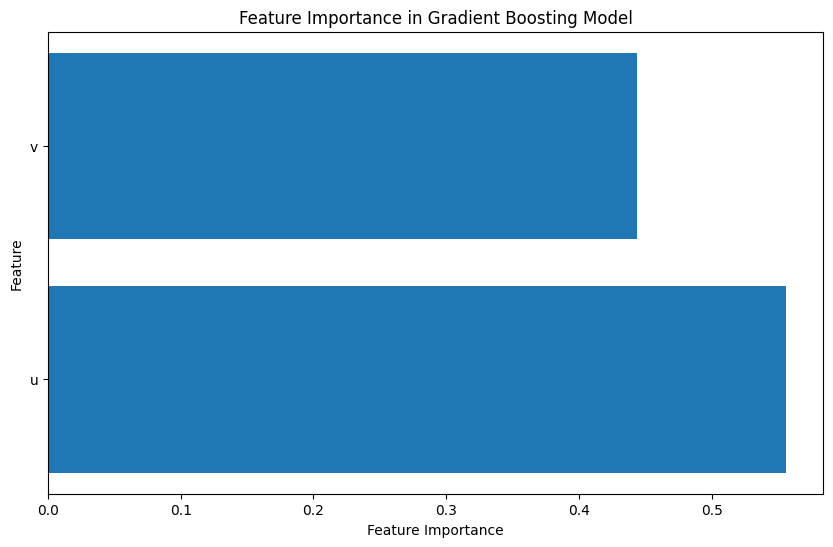

In [ ]:
# Extract feature importances
feature_importances_gbm = gbm.feature_importances_
features = ['u', 'v']  # Adjust based on your features - removed 'linear_feature'

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances_gbm, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Gradient Boosting Model')
plt.show()

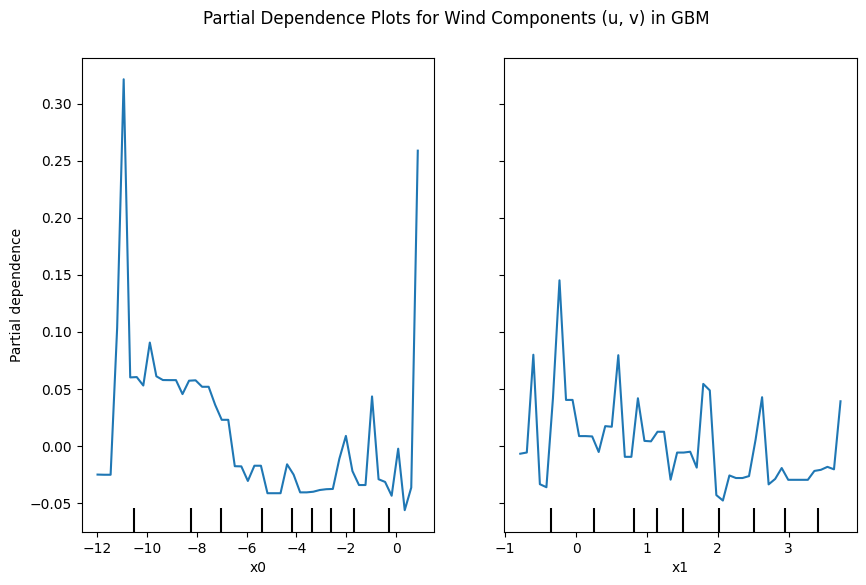

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features = [0, 1]  # 0 for 'u', 1 for 'v'

gbm.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(gbm, X_train, [0, 1], grid_resolution=50, ax=ax)
plt.suptitle('Partial Dependence Plots for Wind Components (u, v) in GBM')
plt.subplots_adjust(top=0.9)
plt.show()